# Описание проекта

Необходимо по фотографии определить приблизительный возраст человека на основе набора фотографий людей с указанием возраста

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.count()

file_name    7591
real_age     7591
dtype: int64

размер выборки невелик для выборки в 7591 размеченное фото с учётом 100 классов, но достаточен для сети ResNet50, поскольку она предобучена на датасете ImageNet с лицами людей. При использовании малой выборки можно заморозить часть слоёв сети без изменения её архитектуры или нарастить выборку, применяя аугментации.

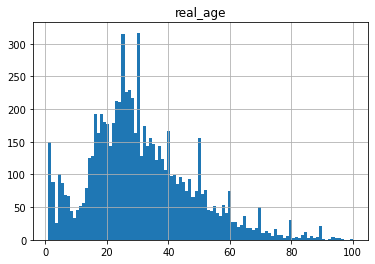

In [ ]:
labels.hist(bins=100);

на гистограмме видны пики каждые 5 лет, что может быть связано с округлением возраста до кратного 5 при разметке. Это может отрицательно повлиять на обучение, но оказаться в пределах допустимой погрешности. Также выделяются пики на 1 и 22-23, что тоже может оказать влияние на обучение и прогноз.

In [ ]:
features, target = next(train_gen_flow)

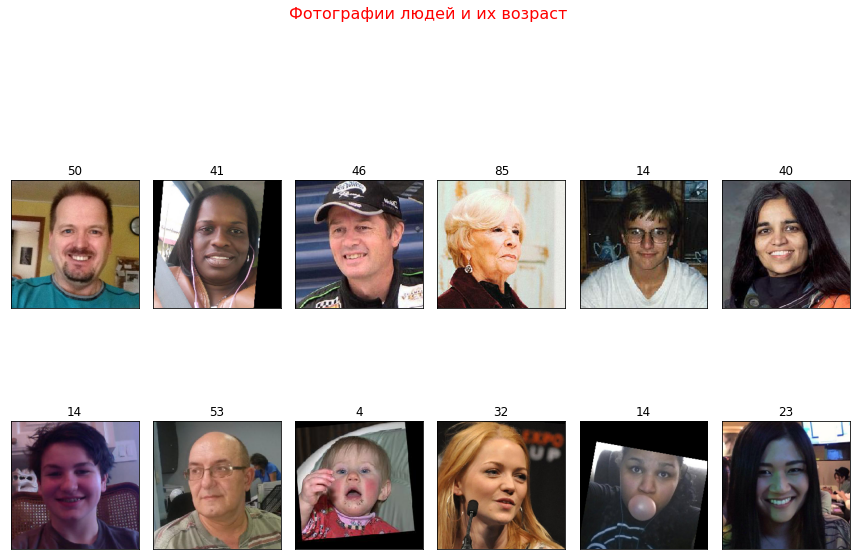

In [ ]:
fig = plt.figure(figsize=(12,12))
for i in range(12):
    fig.add_subplot(2, 6, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.suptitle('Фотографии людей и их возраст',  y=0.9,fontsize=16, color='r')
    plt.tight_layout()

Вывод: распределение двуглавое, в выборке главный пик приходится на людей возрастом 30 лет и второстепенный на малышей возрастом около года. Людей этих возрастов модель сможет определять наилучшим образом. На людях возраста 60+ модель будет ошибаться сильнее. Если это недопустимо для магазина, то следует выравнять распределение.

Некоторые фотографии повёрнуты и искажены. Возможно, аугментация если и потребуется, то незначительная.

Общая ориентация фотографий отражает естественное положение лица человека, т.е. фотографии не перевёрнуты "вверх ногами". Некоторые фотографии повёрнуты на 15-30 градусов, при этом пространство за фотографией чёрное. Повёрнутые фотографии могут быть несколько меньше по размеру. Размер лица на остальных фотографиях примерно одинаковый. Чёрно-белые фотографии встречаются редко, выборка состоит преимущественно из цветных фотографий.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
            validation_split=0.25,
            horizontal_flip=True,
            #vertical_flip=True,
            #rotation_range=90,
            #width_shift_range=0.20,
            #height_shift_range=0.20
            rescale=1/255
            )
    train_datagen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + '/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)
    
    return train_datagen_flow

def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    val_datagen = ImageDataGenerator(
            validation_split=0.25,
            rescale=1/255
            )
    val_datagen_flow = val_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + '/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)
    
    return val_datagen_flow


def create_model(input_shape):

    optimizer = Adam(lr=0.0001)

    backbone = ResNet50(input_shape=input_shape,
                    #classes=1000,
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=7,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
              steps_per_epoch = len(train_data)
    if validation_steps is None:
              validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, epochs=epochs)

    return model

```

```

Epoch 1/7
178/178 - 94s - loss: 252.4614 - mae: 11.4989 - val_loss: 696.5472 - val_mae: 21.4373
Epoch 2/7
178/178 - 38s - loss: 52.8637 - mae: 5.4797 - val_loss: 1071.4036 - val_mae: 28.1437
Epoch 3/7
178/178 - 38s - loss: 26.6267 - mae: 4.0332 - val_loss: 484.9214 - val_mae: 16.9992
Epoch 4/7
178/178 - 38s - loss: 22.3813 - mae: 3.6597 - val_loss: 197.8562 - val_mae: 10.4219
Epoch 5/7
178/178 - 38s - loss: 24.0980 - mae: 3.7748 - val_loss: 100.3411 - val_mae: 7.5975
Epoch 6/7
178/178 - 38s - loss: 23.7836 - mae: 3.7708 - val_loss: 93.7803 - val_mae: 7.5050
Epoch 7/7
178/178 - 38s - loss: 21.7407 - mae: 3.5967 - val_loss: 87.7560 - val_mae: 7.2501

```

## Анализ обученной модели

Вывод: Модель обучена на выборке из 7591 размеченных фотографий. Выборка несбалансирована и наиболее освещённая возрастная группа от 20 до 30 лет, а также дети дошкольного возраста. Валидационная выборка составила 25%. Использована трёхслойная нейронная сеть ResNet50 без аугментации. Результат по метрике mae составил менее 8, что достаточно для выполнения задачи распознавания возраста по фотографии для данного магазина. Задача бизнеса по определению возраста покупателя должна быть решена, поскольку наиболее освещённая разметкой группа относится к наиболее активной с точки зрения покупательской активности.